[!toc]

# Advanced Model 
Gradient boosting decision tree

In [1]:
from pathlib import Path
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report,roc_curve, auc, plot_roc_curve, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_validate, StratifiedShuffleSplit, StratifiedKFold, cross_val_score
from sklearn.utils import resample
from sklearn import preprocessing

In [2]:
from imblearn.over_sampling import SMOTE 
from collections import Counter

In [3]:
from feature_selection.feature_selection import feature_selection, feature_selection_for_detection
from splitter import splitter

In [4]:
pred_path = "../files/SeizurePrediction/"
dect_path = "../files/SeizureDetection/"

## Prediction

### Feature Selection

In [4]:
file_list = list(Path(pred_path).glob("*.csv"))
samples = [f.name.split('.')[0] for f in file_list]

In [5]:
file_list[0].parent

WindowsPath('../files/SeizurePrediction')

In [6]:
res = pd.DataFrame(data_x)
res["result"] = data_y
res

NameError: name 'data_x' is not defined

In [16]:
file_list = [f for f in Path(dect_path).glob("*atient*.csv") if "reduced" not in f.name]
for f in file_list:
    # data = pd.read_csv(f.resolve(), header=None)
    sample = f.name.split('.')[0]
    print('='*10,sample,'='*10)
    data_x,data_y = feature_selection_for_detection(f.resolve())
    res = pd.DataFrame(data_x)
    res["result"] = data_y
    res.to_csv(os.path.join(f.parent.resolve(), sample+"_reduced.csv"), index=False)

========== Patient_1 ==========
Number of Observation(raw): 1044
Number of features(raw): 1905
Fitting 5 folds for each of 20 candidates, totalling 100 fits
========== Patient_2 ==========
Number of Observation(raw): 3141
Number of features(raw): 449
Fitting 5 folds for each of 20 candidates, totalling 100 fits
========== Patient_3 ==========
Number of Observation(raw): 1041
Number of features(raw): 1541
Fitting 5 folds for each of 20 candidates, totalling 100 fits
========== Patient_4 ==========
Number of Observation(raw): 210
Number of features(raw): 2017
Fitting 5 folds for each of 20 candidates, totalling 100 fits
========== Patient_5 ==========
Number of Observation(raw): 2745
Number of features(raw): 1793
Fitting 5 folds for each of 20 candidates, totalling 100 fits
========== Patient_6 ==========
Number of Observation(raw): 2997
Number of features(raw): 841
Fitting 5 folds for each of 20 candidates, totalling 100 fits
========== Patient_7 ==========
Number of Observation(raw): 3

In [ ]:
file_list = list(Path(pred_path).glob("*.csv"))
for f in file_list:
    # data = pd.read_csv(f.resolve(), header=None)
    sample = f.name.split('.')[0]
    print('='*10,sample,'='*10)
    data_x,data_y = feature_selection(f.resolve())
    res = pd.DataFrame(data_x)
    res["result"] = data_y
    res.to_csv(os.path.join(f.parent.resolve(), sample+"_reduced.csv"), index=False)

### balance data

In [5]:
def balance_data(data_x, data_y,verbose=False):
    if verbose: print('Original dataset shape %s' % Counter(data_y))
    sm = SMOTE()
    X_res, y_res = sm.fit_resample(data_x, data_y)
    if verbose: print('Resampled dataset shape %s' % Counter(y_res))
    return X_res, y_res

def scale_data(x):
    train_scaler = preprocessing.StandardScaler().fit(x)
    return train_scaler.transform(x)


### gbdt

In [6]:
def print_statistics(y_test, y_pred,i=None):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn+fp)
    sensitivity = tp / (tp+fn)
    accuracy = (tp+tn)/(tp+fn+fp+tn)
    PPV = tp / (tp+fp)
    f1 =  2*((PPV*sensitivity)/(PPV+sensitivity))
    print("{:^5d},{:^15.4f},{:^15.4f},{:^15.4f},{:^15.4f},{:^15.4f}".format(i,specificity,sensitivity,accuracy,PPV,f1))

def train_pred(X, y, save=False):
    cv = StratifiedKFold(5,shuffle = True, random_state=2021534)
    tprs = []
    aucs = []
    
    originalclass = []
    predictedclass = []

    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots(figsize=(8,6))
    print("{:^5s},{:^15s},{:^15s},{:^15s},{:^15s},{:^15s}".format("fold","specificity","sensitivity",'accuracy','PPV','f1'))
    for i, (train, test) in enumerate(cv.split(X, y)):
        X_train, y_train = balance_data(X[train], y[train])
        scaler = preprocessing.StandardScaler().fit(X[train])
        X_train = scaler.transform(X_train)
        X_test, y_test = X[test], y[test]
        X_test = scaler.transform(X_test)
        gradient_boosting = GradientBoostingClassifier(n_estimators=200,max_features='sqrt',random_state=2021).fit(X_train, y_train)
#         y_pred = gradient_boosting.predict(X_test)
                
        y_hat = gradient_boosting.predict_proba(X_test)[:, 1]
        # Calculate the ROC Curves
        fpr, tpr, thresholds = roc_curve(y_test, y_hat)
        gmeans = np.sqrt(tpr * (1-fpr))
        
        ix = np.argmax(gmeans)
        y_pred = gradient_boosting.predict_proba(X_test)[:,1] >= thresholds[ix]
        ax.scatter(fpr[ix], tpr[ix], marker='o', color='red', alpha=0.3)
        originalclass.extend(y_test)
        predictedclass.extend(y_pred)
        
        viz = plot_roc_curve(gradient_boosting, X_test, y_test,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
        
        # basic statistics
        print_statistics(y_test, y_pred,i)
        print_statistics(y_test, gradient_boosting.predict(X_test),i)
        
    print(classification_report(originalclass, predictedclass))
    
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)
    
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
    ax.legend(loc="lower right")
    if save:
        plt.savefig(os.path.join("./figures", "gbdt_rocaoc_pred_{}.pdf".format(save)))
    plt.show()
    return aucs


In [7]:
# aucs = train_pred(data_x, data_y)

## main

========== Dog_1_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.8340     ,    0.6154     ,    0.8234     ,    0.1584     ,    0.2520     
  0  ,    0.9473     ,    0.3462     ,    0.9182     ,    0.2500     ,    0.2903     
  1  ,    0.6934     ,    0.6538     ,    0.6914     ,    0.0977     ,    0.1700     
  1  ,    0.9297     ,    0.2308     ,    0.8959     ,    0.1429     ,    0.1765     
  2  ,    0.8262     ,    0.6154     ,    0.8160     ,    0.1524     ,    0.2443     
  2  ,    0.9238     ,    0.5000     ,    0.9033     ,    0.2500     ,    0.3333     
  3  ,    0.5547     ,    0.7200     ,    0.5624     ,    0.0732     ,    0.1328     
  3  ,    0.9355     ,    0.1600     ,    0.8994     ,    0.1081     ,    0.1290     
  4  ,    0.7520     ,    0.6800     ,    0.7486     ,    0.1181     ,    0.2012     
  4  ,    0.9395     ,    0.2800     ,    0.9088     ,    0.1842     ,    0.2222     
              prec

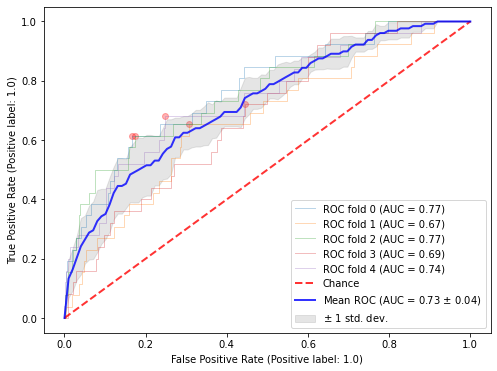

[0.7732872596153846, 0.6697716346153846, 0.7652493990384616, 0.686328125, 0.7406250000000001]
0.7270522836538462
========== Dog_2_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.8933     ,    0.9545     ,    0.8979     ,    0.4242     ,    0.5874     
  0  ,    0.9551     ,    0.8409     ,    0.9464     ,    0.6066     ,    0.7048     
  1  ,    0.9118     ,    0.8444     ,    0.9066     ,    0.4471     ,    0.5846     
  1  ,    0.9531     ,    0.7333     ,    0.9360     ,    0.5690     ,    0.6408     
  2  ,    0.8612     ,    0.9556     ,    0.8685     ,    0.3675     ,    0.5309     
  2  ,    0.9531     ,    0.8000     ,    0.9412     ,    0.5902     ,    0.6792     
  3  ,    0.8236     ,    0.9556     ,    0.8339     ,    0.3139     ,    0.4725     
  3  ,    0.9512     ,    0.7111     ,    0.9325     ,    0.5517     ,    0.6214     
  4  ,    0.8705     ,    0.9556     ,    0.8772     ,    0.3839     ,    0.5

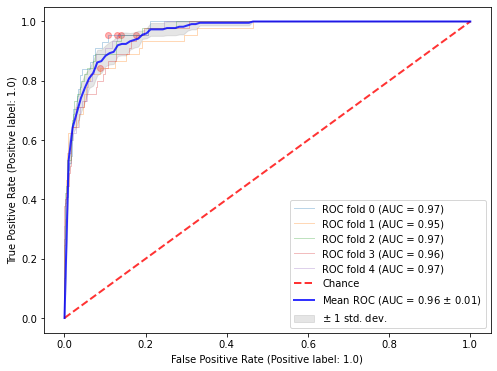

[0.9713993871297242, 0.9488013341671879, 0.9682718365645195, 0.9572232645403378, 0.9654367312903898]
0.9622265107384319
========== Dog_3_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9414     ,    0.9221     ,    0.9405     ,    0.4410     ,    0.5966     
  0  ,    0.9922     ,    0.7792     ,    0.9820     ,    0.8333     ,    0.8054     
  1  ,    0.9642     ,    0.9221     ,    0.9622     ,    0.5635     ,    0.6995     
  1  ,    0.9915     ,    0.7662     ,    0.9808     ,    0.8194     ,    0.7919     
  2  ,    0.9206     ,    0.8831     ,    0.9188     ,    0.3579     ,    0.5094     
  2  ,    0.9863     ,    0.7143     ,    0.9733     ,    0.7237     ,    0.7190     
  3  ,    0.8464     ,    0.9610     ,    0.8518     ,    0.2387     ,    0.3824     
  3  ,    0.9896     ,    0.5974     ,    0.9709     ,    0.7419     ,    0.6619     
  4  ,    0.9277     ,    0.9211     ,    0.9274     ,    0.3867     ,

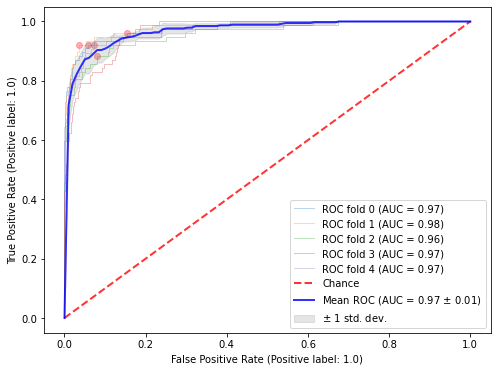

[0.9738822375541126, 0.9807731331168831, 0.9645224567099566, 0.9684033414502164, 0.9695466694078947]
0.9714255676478128
========== Dog_4_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.8217     ,    0.9423     ,    0.8347     ,    0.3904     ,    0.5521     
  0  ,    0.8928     ,    0.8269     ,    0.8857     ,    0.4831     ,    0.6099     
  1  ,    0.8485     ,    0.8846     ,    0.8524     ,    0.4144     ,    0.5644     
  1  ,    0.8939     ,    0.7981     ,    0.8836     ,    0.4770     ,    0.5971     
  2  ,    0.8392     ,    0.7981     ,    0.8347     ,    0.3756     ,    0.5108     
  2  ,    0.9033     ,    0.7115     ,    0.8825     ,    0.4713     ,    0.5670     
  3  ,    0.8075     ,    0.8942     ,    0.8169     ,    0.3605     ,    0.5138     
  3  ,    0.8880     ,    0.7788     ,    0.8762     ,    0.4576     ,    0.5765     
  4  ,    0.8845     ,    0.8077     ,    0.8762     ,    0.4590     ,

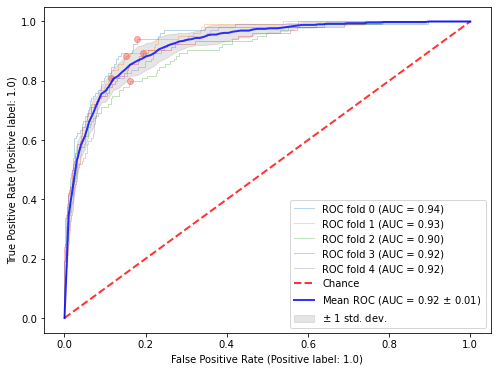

[0.9395284202976509, 0.9324009324009325, 0.8974358974358974, 0.9179045866618796, 0.9212705322681985]
0.9217080738129118
========== Dog_5_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9625     ,    0.9688     ,    0.9629     ,    0.6327     ,    0.7654     
  0  ,    0.9854     ,    0.8750     ,    0.9785     ,    0.8000     ,    0.8358     
  1  ,    0.9688     ,    1.0000     ,    0.9707     ,    0.6809     ,    0.8101     
  1  ,    0.9854     ,    0.8438     ,    0.9766     ,    0.7941     ,    0.8182     
  2  ,    0.9812     ,    1.0000     ,    0.9824     ,    0.7805     ,    0.8767     
  2  ,    0.9896     ,    0.9375     ,    0.9863     ,    0.8571     ,    0.8955     
  3  ,    0.9938     ,    1.0000     ,    0.9941     ,    0.9143     ,    0.9552     
  3  ,    0.9958     ,    0.9688     ,    0.9941     ,    0.9394     ,    0.9538     
  4  ,    0.9771     ,    1.0000     ,    0.9785     ,    0.7442     ,

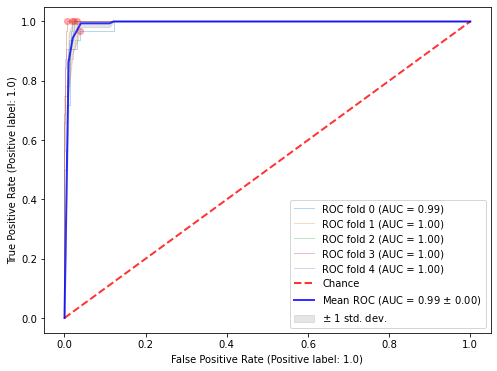

[0.9903645833333333, 0.9953776041666667, 0.9973307291666667, 0.9989583333333334, 0.9973307291666667]
0.9958723958333333
========== Patient_1_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  0  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  1  ,    1.0000     ,    0.9500     ,    0.9867     ,    1.0000     ,    0.9744     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    1.0000     ,    0.9500     ,    0.9867     ,    1.0000     ,    0.9744     
  3  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  3  ,    1.0000     ,    0.9000     ,    0.9733     ,    1.0000     ,    0.9474     
  4  ,    0.9818     ,    1.0000     ,    0.9865     ,    0.9500  

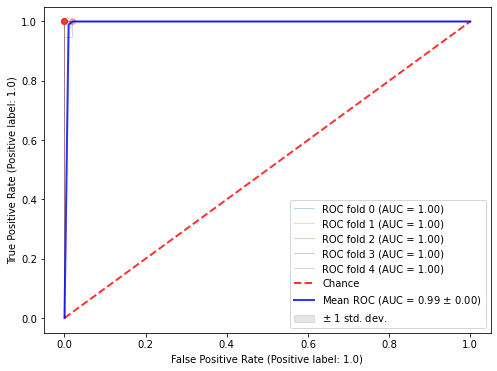

[1.0, 1.0, 1.0, 1.0, 0.999043062200957]
0.9998086124401914
========== Patient_2_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  0  ,    1.0000     ,    0.9474     ,    0.9848     ,    1.0000     ,    0.9730     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    1.0000     ,    0.9500     ,    0.9848     ,    1.0000     ,    0.9744     
  3  ,    0.9783     ,    1.0000     ,    0.9848     ,    0.9524     ,    0.9756     
  3  ,    0.9348     ,    1.0000     ,    0.9545     ,    0.8696     ,    0.9302     
  4  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  4  ,    1.0000     ,    1.0000     ,   

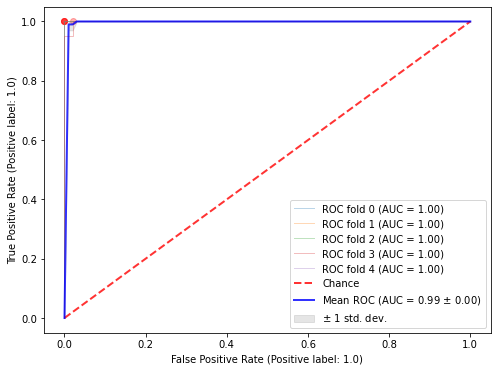

[1.0, 1.0, 1.0, 0.9989130434782609, 1.0]
0.9997826086956522


In [7]:
file_list = [f for f in Path(pred_path).glob("*_reduced.csv")]
for f in file_list:
    data = pd.read_csv(f.resolve())
    sample = f.name.split('.')[0]
    print('='*10, sample ,'='*10)
    data_y = data["result"].to_numpy()
    data_x = data.loc[:, data.columns != 'result'].to_numpy()
    aucs = train_pred(data_x, data_y,save=sample)
    print(aucs)
    print(np.mean(aucs))